## Installations

In [45]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import libraries

In [46]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
from matplotlib import pyplot as plt

from time import sleep
import os
import json

In [47]:
# Initialize CoppeliaSim
client = RemoteAPIClient()
sim = client.require('sim')

In [48]:
fullFolder = os.getcwd() # get the current file location 

# Please select which room you like

# sceneFile = 'room1.ttt'
# sceneFile = 'room2.ttt'
sceneFile = 'room3.ttt'

SCENE = os.path.join(fullFolder, sceneFile)

# Load the scene
sim.loadScene(SCENE)

1

## Collecting Raw Training Data

In [49]:
# enable the stepping mode on the client:
sim.setStepping(True)

sim.startSimulation()

In [50]:
# Get object handles
joint = sim.getObject('./Revolute_joint')
proximSensor = sim.getObject('./Proximity_sensor')

C:\Users\Hannan Shah\AppData\Local\Temp\ipykernel_16048\3075142881.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


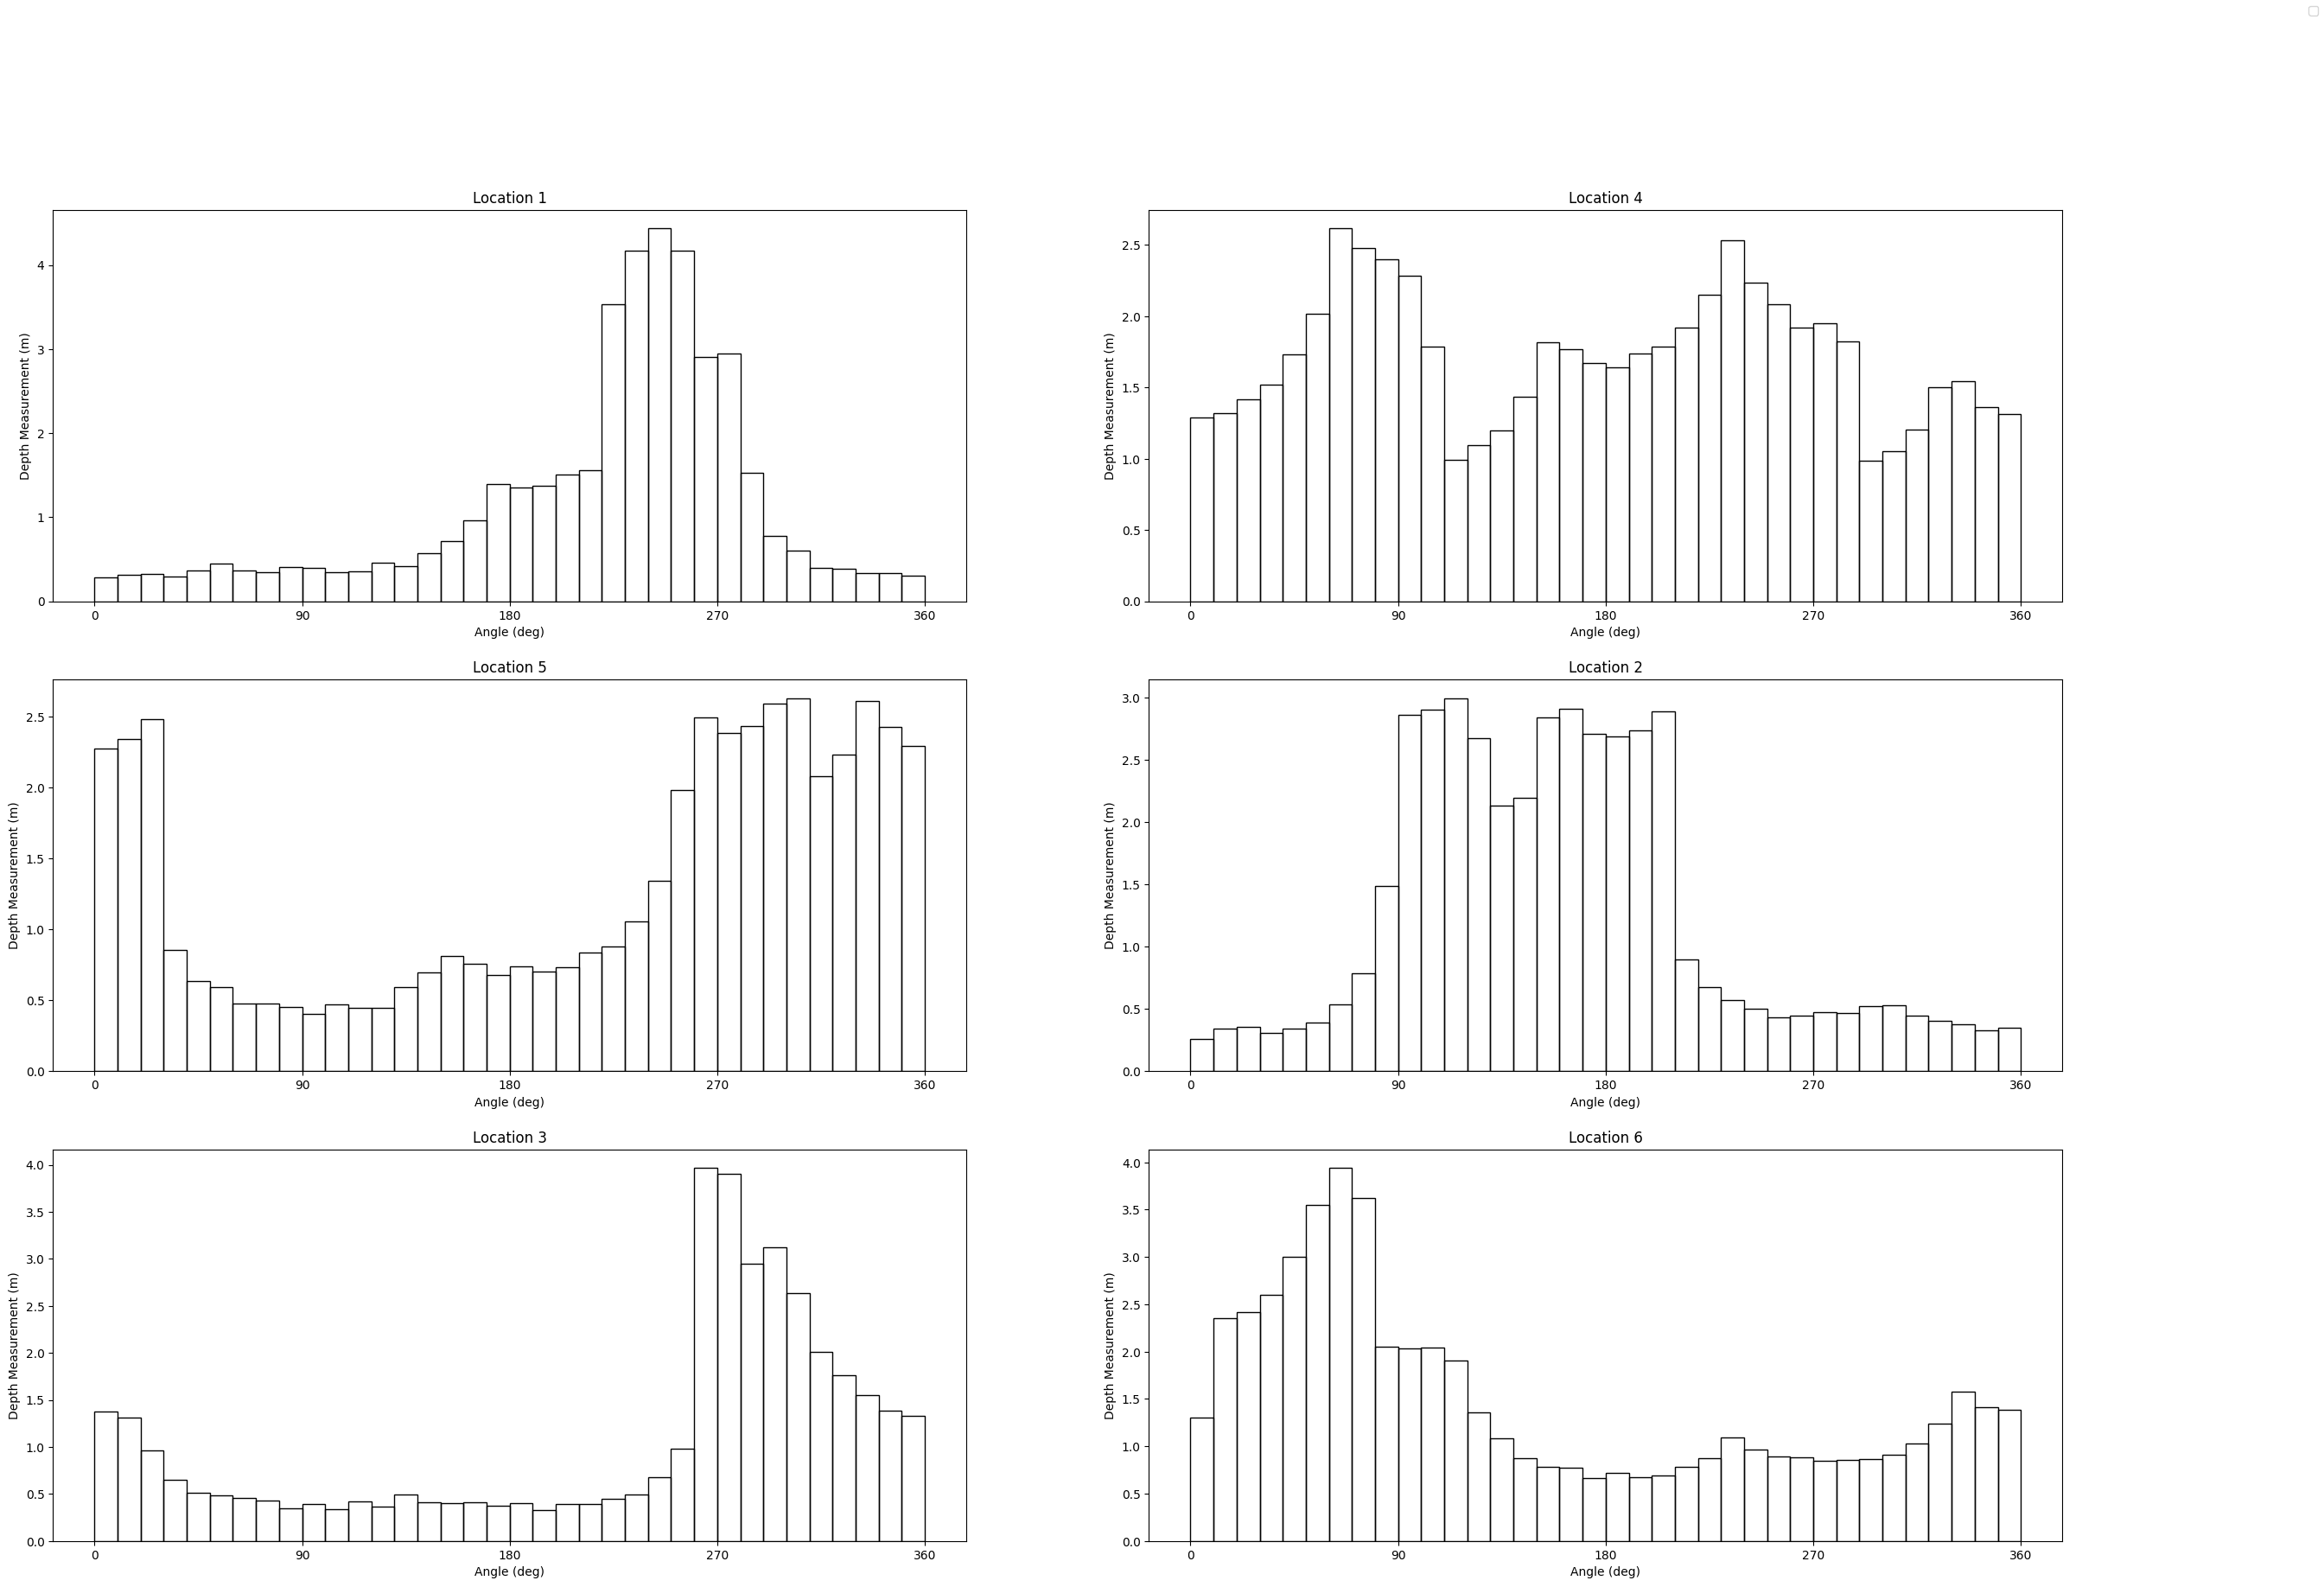

In [51]:
locations = []


start = np.deg2rad(0) #
end = np.deg2rad(360) #

N = 36 #

z = 0.1 # height above the ground




angles = np.linspace(start, end, N, endpoint=False)  # split 0 - 2*pi into 36 samples, excluding the endpoint
angles_deg = np.rad2deg(angles)

width = 360 / N  # width of the bar in degrees


# Prepare plotting
fig, axs = plt.subplots(3, 2)
fig.set_figwidth(30)
fig.set_figheight(20)

for i in range(6):
    id = sim.getObject('./location', {'index':i}) # get the handle of the 6 locations
    
    pose = sim.getObjectPose(id) # get Pose [position(3), quaternion(4)] (x, y, z, xi, yi, zi, w)
    pose[2] = z 
    
    sensorData = []
    sim.setObjectPose(joint, pose) # place sensor above ground

    for theta in angles: 
        sim.setJointPosition(joint, theta) # rotate sensor
        
        sim.step() # step simulation

        dist = sim.readProximitySensor(proximSensor) # read distance
        noise = np.random.uniform(low=0, high=0.1) # generate noise
        # sensorData += noise
        depth = dist[1] + noise # add noise
        sensorData.append(depth) 


    location = {
        'dummy-id': id,
        'loc-id':i,
        'pose':pose,
        'sensorData':sensorData
    }

    # Plot 
    ax = axs[i%3][i%2]
    ax.bar(angles_deg, sensorData, width=(width), color = 'None', edgecolor = 'black', align='edge')
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('Depth Measurement (m)')
    ax.set_title(f'Location {i+1}')
    ax.set_xticks([0, 90, 180, 270, 360])  
    ax.set_xticklabels([0, 90, 180, 270, 360])  

    locations.append(location)
    sleep(0.5)
    # pose

fig.legend()
fig.savefig('data_collect_low')#,dpi=600)

In [52]:
# stop simulation
sim.stopSimulation()

In [53]:
# Dump data to file
with open('sensorData.json', 'w') as fp:
    fp.writelines(json.dumps(locations))

## Building Augumented Training Dataset

#### Replicate Data by rotating 
Using just the orginal data is insuficient 

- [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]
- [350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340]
- [340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330]
- [330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320]
- [320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310]
- [310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
- [300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]
- [290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280]
- [280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270]
- [270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]
- [260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
- [250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]
- [240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]
- [230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220]
- [220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]
- [210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
- [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
- [190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]
- [180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
- [170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
- [160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
- [150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
- [140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
- [130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
- [120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
- [110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
- [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
- [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80]
- [80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70]
- [70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60]
- [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50]
- [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40]
- [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30]
- [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20]
- [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10]
- [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 0]


In [54]:
# 
X = []
y = []

for loc_id, location in enumerate(locations):
    originalData = location['sensorData']
    loc_id = location['loc-id']
    for i in range(N):
        X.append(originalData.copy())
        y.append(loc_id)
        originalData = [originalData.pop()] + originalData

X_train = np.array(X)
y_train = np.array(y)

## Collecting Testing Data

In [55]:
# enable the stepping mode on the client:
sim.setStepping(True)

sim.startSimulation()

location-id: 5; starting-angle: 330.3046541170486
location-id: 3; starting-angle: 293.69654398028337
location-id: 2; starting-angle: 28.439876979999678
location-id: 3; starting-angle: 142.8402516019151
location-id: 4; starting-angle: 27.083055581089777
location-id: 1; starting-angle: 266.2310733312887


C:\Users\Hannan Shah\AppData\Local\Temp\ipykernel_16048\612392090.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


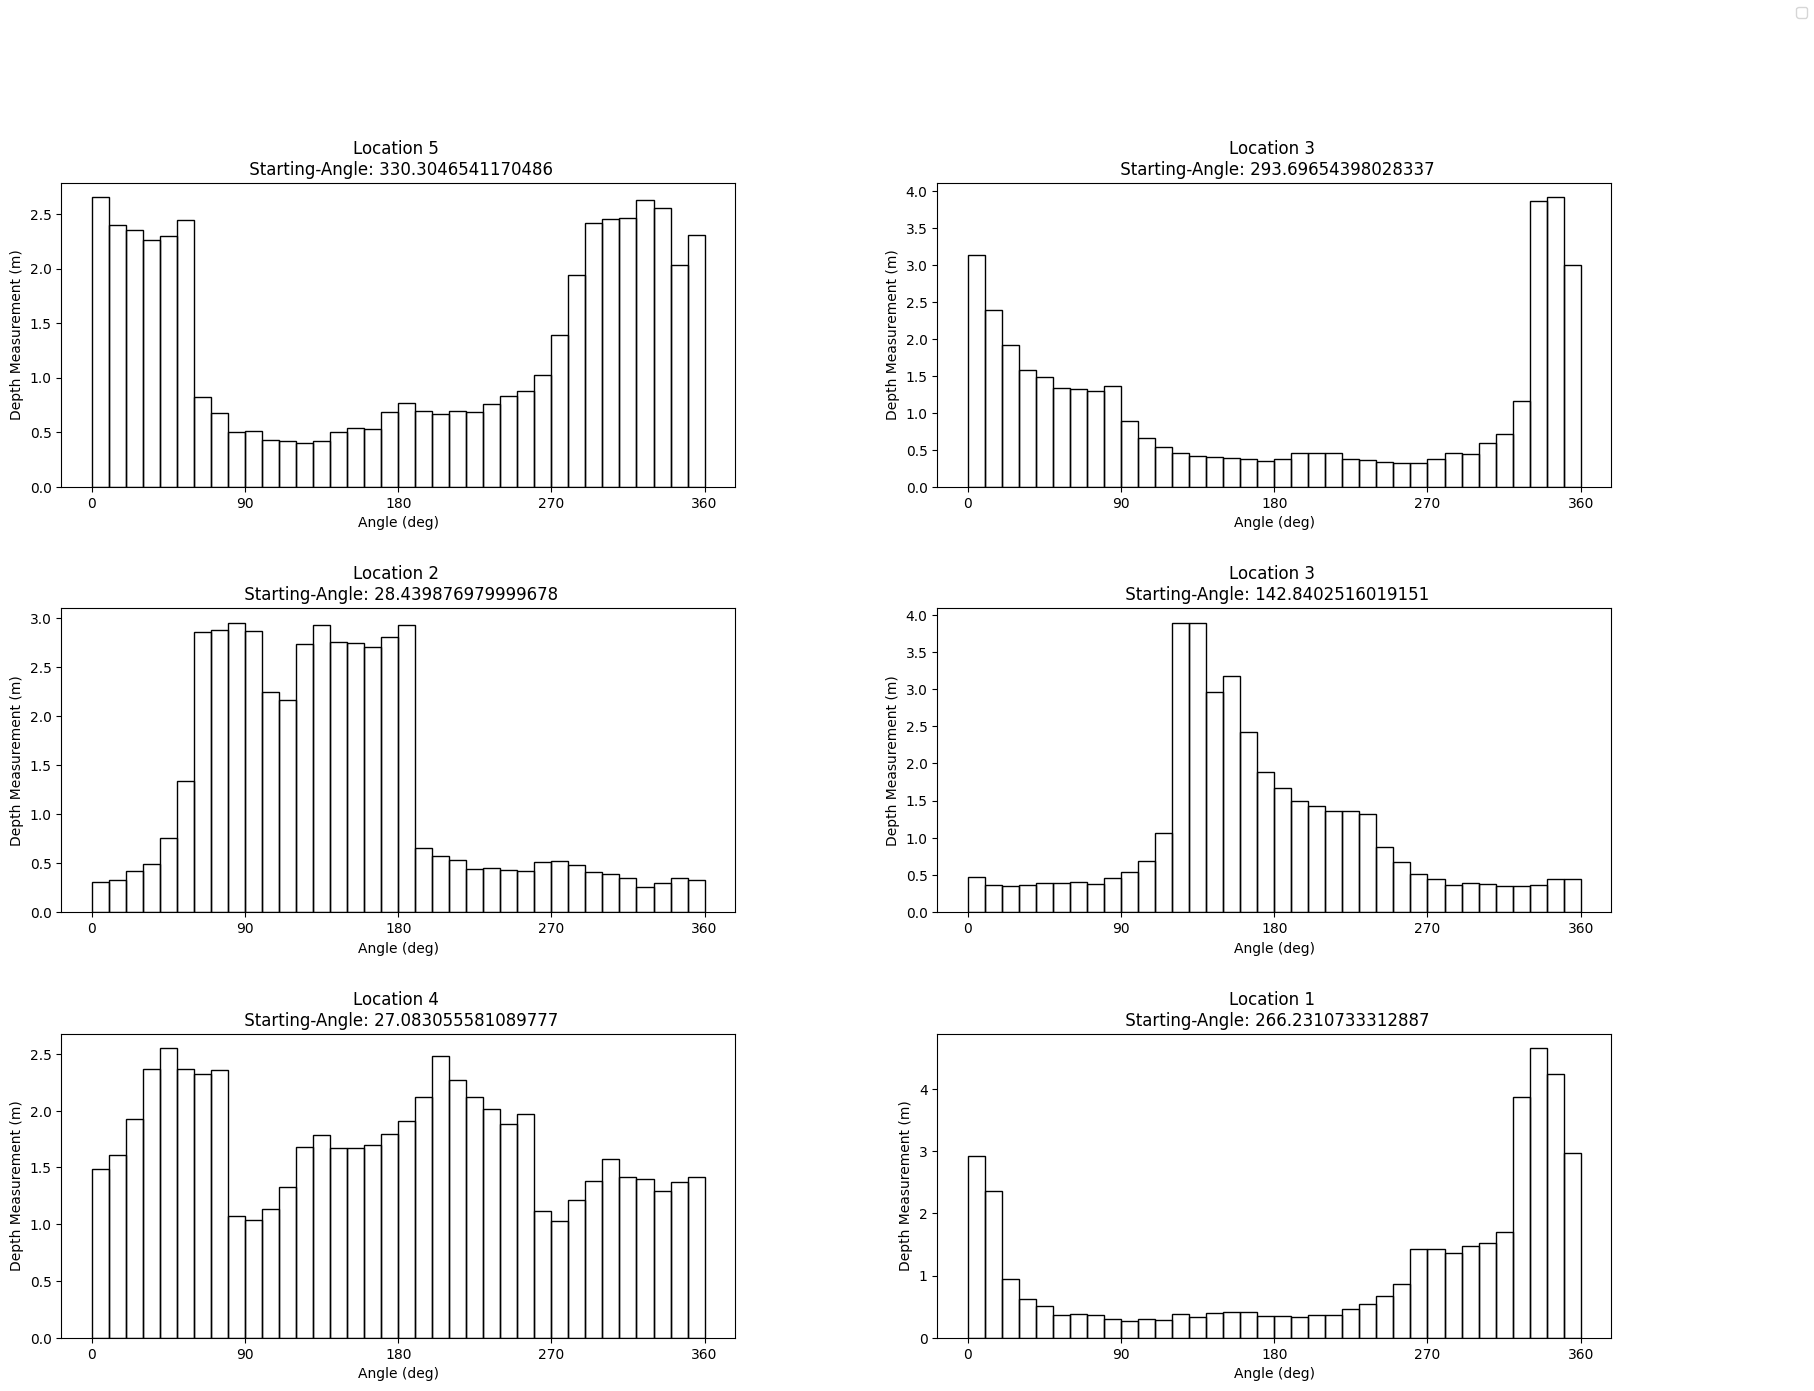

In [56]:


# Assuming you have sim and other required objects initialized

# Parameters
locations = []

start = np.deg2rad(0)  # start angle in radians
end = np.deg2rad(360)  # end angle in radians

N = 36  # number of samples

z = 0.1  # height above the ground

angles = np.linspace(start, end, N, endpoint=False)  # split 0 - 2*pi into 36 samples, excluding the endpoint
angles_deg = np.rad2deg(angles)

width = 360 / N  # width of the bar in degrees

# Prepare plotting
fig, axs = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

sample_locs = 6
locations_test = []

for i in range(sample_locs):
    loc_id = np.random.randint(6)  # randomly choose location 0 - 6
    start_heading = np.random.uniform(low=0, high=(2 * np.pi))  # randomly choose starting angle for the sensor
    
    print(f"location-id: {loc_id +1}; starting-angle: {np.rad2deg(start_heading)}")
    
    id = sim.getObject('./location', {'index': loc_id})
    pos = sim.getObjectPosition(id)
    ori = sim.getObjectOrientation(id)
    pos[2] = z
    ori[2] = start_heading

    sim.setObjectPosition(joint, pos)
    sim.setObjectOrientation(joint, ori)
    sensorData = []
    for theta in angles:
        sim.setJointPosition(joint, theta)
        sim.step()
        dist = sim.readProximitySensor(proximSensor)
        
        noise = np.random.uniform(low=0, high=0.1)  # generate noise
        
        depth = dist[1] + noise  # add noise
        sensorData.append(depth)
    pose = pos + ori
    location = {
        'dummy-id': id,
        'loc-id': loc_id,
        'pose': pose,
        'sensorData': sensorData
    }
    locations_test.append(location)

    # Plot 
    ax = axs[i // 2, i % 2]
    ax.bar(angles_deg, sensorData, width=(width), color='None', edgecolor='black', align='edge')
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('Depth Measurement (m)')
    ax.set_title(f'Location {loc_id+1} \n Starting-Angle: {np.rad2deg(start_heading)}')
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    sleep(0.5)

fig.legend()
fig.savefig('data_collect_test')  # ,dpi=600

# Optionally display the plot
plt.show()

    

In [57]:
# Initialize Testing Data
X = []
y = []
for location in locations_test:

    X.append(location['sensorData'])
    y.append(location['loc-id'])

X_test = np.array(X)
y_test = np.array(y)
X_test.shape

(6, 36)

In [58]:
# Dump data to file
with open('testSensorData.json', 'w') as fp:
    fp.writelines(json.dumps(locations_test))

In [59]:
sim.stopSimulation()

### Classifier Algorithm

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

### Initialize Preprocessing and KNN Algorithm

In [61]:

clf = KNeighborsClassifier(3) # initiate KNN algorithm
clf = make_pipeline(StandardScaler(), clf) # preprocess with Standard Scaler

### Execute Training

In [62]:

clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

### Execute Testing

In [63]:
# print(len(X_test),len(y_test))


score = clf.score(X_test, y_test)
print (f'Accuracy: {score *100}%')

Accuracy: 100.0%


### Get actual prediction

In [64]:
y_pred = clf.predict(X_test)
y_test+1, y_pred+1





for i, (actual, predicted) in enumerate(zip(y_test+1, y_pred+1), 1):
    print(f"Test {i}: Actual location id: {actual}  Predicted location id: {predicted}")


Test 1: Actual location id: 5  Predicted location id: 5
Test 2: Actual location id: 3  Predicted location id: 3
Test 3: Actual location id: 2  Predicted location id: 2
Test 4: Actual location id: 3  Predicted location id: 3
Test 5: Actual location id: 4  Predicted location id: 4
Test 6: Actual location id: 1  Predicted location id: 1


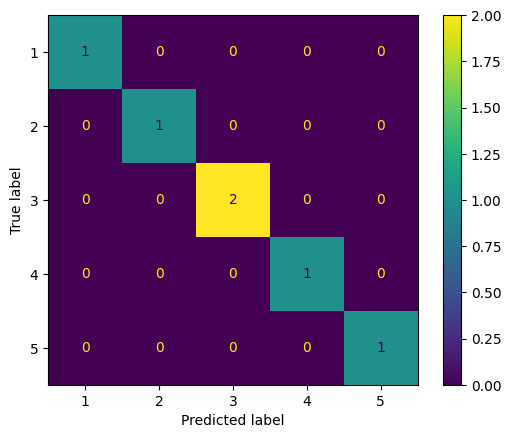

In [65]:
ConfusionMatrixDisplay.from_predictions(y_test+1, y_pred+1)
plt.savefig('ConfusionMatrix')

In [66]:
# close scene
sim.closeScene()

0